In [1]:
import datetime
from datetime import datetime
import random
import calendar
import time
import sklearn
import statsmodels.api as sm
import pandas as pd 
from matplotlib.lines import Line2D
import numpy as np
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
import matplotlib.ticker as mtick
import matplotlib.collections as collections
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn import linear_model, datasets, preprocessing
from statsmodels.tsa.arima_model import ARIMA
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from scipy import stats
from copy import deepcopy
from datetime import datetime
from WindPy import w
from numpy import linalg
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [44]:
int_list = [['M0020188','股票'],['S0105896','商品'],['M1004271','10债'],['M1004263','1债']]

#起止时间
t0 = '2004-06-01'
t1 = '2020-10-01'

#指数取值周期
dic = {'D':'天', 'W':'周', 'M':'月', 'Q':'季度', 'S':'半年', 'Y':'年'}
prd = 'M'

#利用当前时间prdit前连续itv个周期的数据
itv, prdit = 4, 1

ind_list = []
for i in int_list:
    ind_list.append(i[0])

df = w.wsd(ind_list, 'close', t0, '-1D', Period = prd, Fill = 'Previous')

#训练比例
r = .6

#指数与日期
data = df.Data
date = df.Times

#斜率判断
slp = 4

#平滑区间
c_s = 4

# 数据加工

In [13]:
pro_df = []
origin = 0

for i in range(len(date) - itv - prdit + 2):
    temp = []
    for j in range(len(data)):
        
        #value指数
        if origin == 1:
            temp.append(data[j][i + itv + prdit - 1])
            
        df = data[j][i:i+itv]
        
        #average平均值
        temp.append(sum(df)/itv)
        
        #spike反转数
        spike = 0
        dirc = -(-1) ** (df[1] > df[0]) 
        for k in range(1,itv-1):
            spike += (-(-1) ** (df[k+1] > df[k]) != dirc)
            dirc = -(-1) ** (df[k+1] > df[k])
        temp.append(spike)
        
        #slope头尾斜率
        temp.append((df[-1]/df[0])-1)
        
        #height极值差距
        temp.append(max(df)-min(df))
        
        #direction头尾方向
        temp.append(-(-1) ** (df[-1] > df[0]))
        
    pro_df.append(temp)

sh = data[0]
nh = data[1]
z10 = data[2]
z1 = data[3]
d8 = date
si = int(r * len(d8[itv+prdit-1:]))

d8y, d8m = d8[-1].year, d8[-1].month
if d8m == 12:
    d8m = 1
    d8y += 1
else:
    d8m += 1
wd, d8d = calendar.monthrange(d8y, d8m)
new_d8 = d8[-1].replace(year = d8y, month = d8m, day = d8d)
d8.append(new_d8)

# 线性回归

In [4]:
d8_tr = (d8[itv+prdit-1:])[:si]
d8_vd = (d8[itv+prdit-1:])[si:]
df_tr = pro_df[:si]
df_vd = pro_df[si:]
sh_tr = sh[itv+prdit-1:][:si]
sh_vd = sh[itv+prdit-1:][si:]
mod_lr = LinearRegression()
mod_lr.fit(df_tr, sh_tr)
tr_prd = mod_lr.predict(df_tr)
vd_prd = mod_lr.predict(df_vd)
t_prd = [i for i in tr_prd] + [j for j in vd_prd]

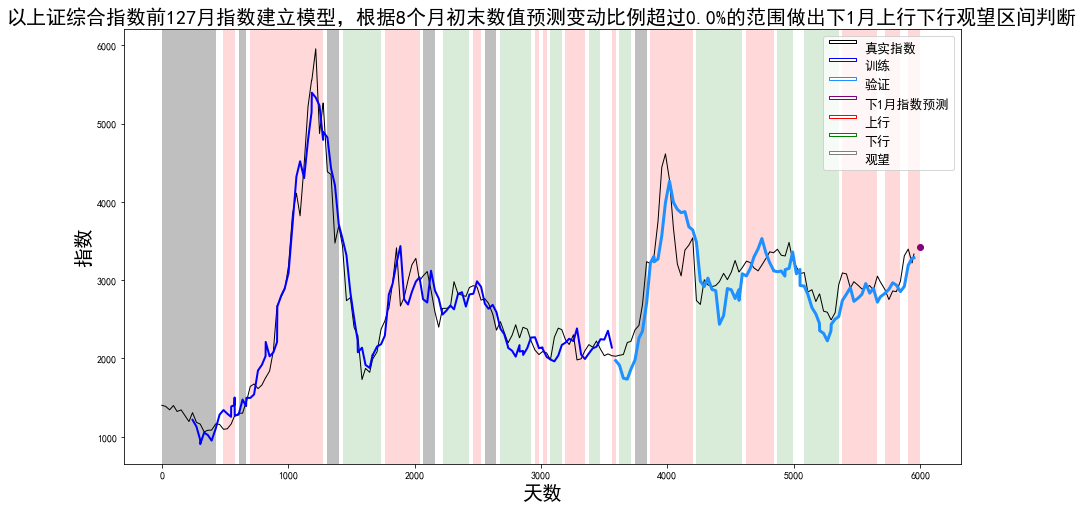

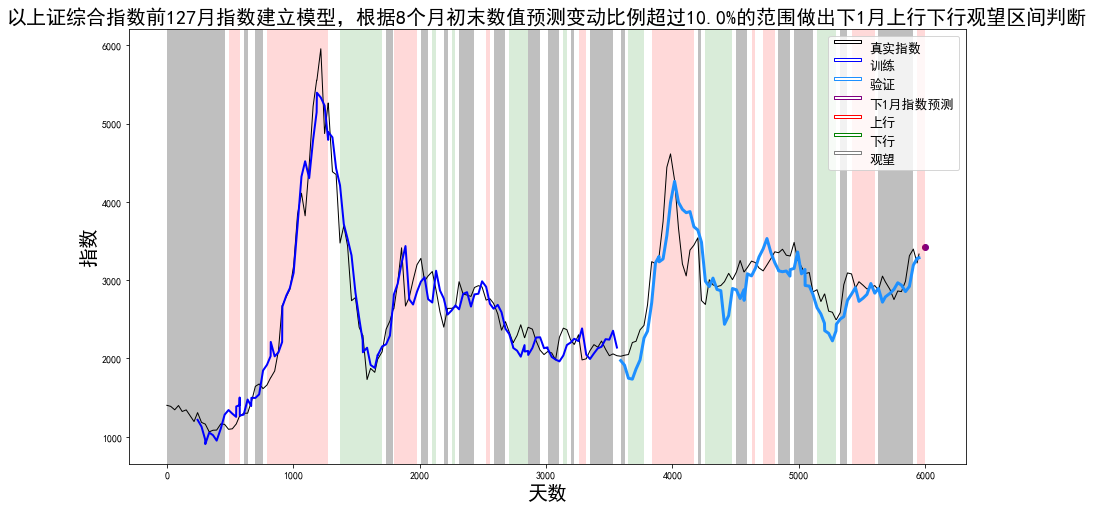

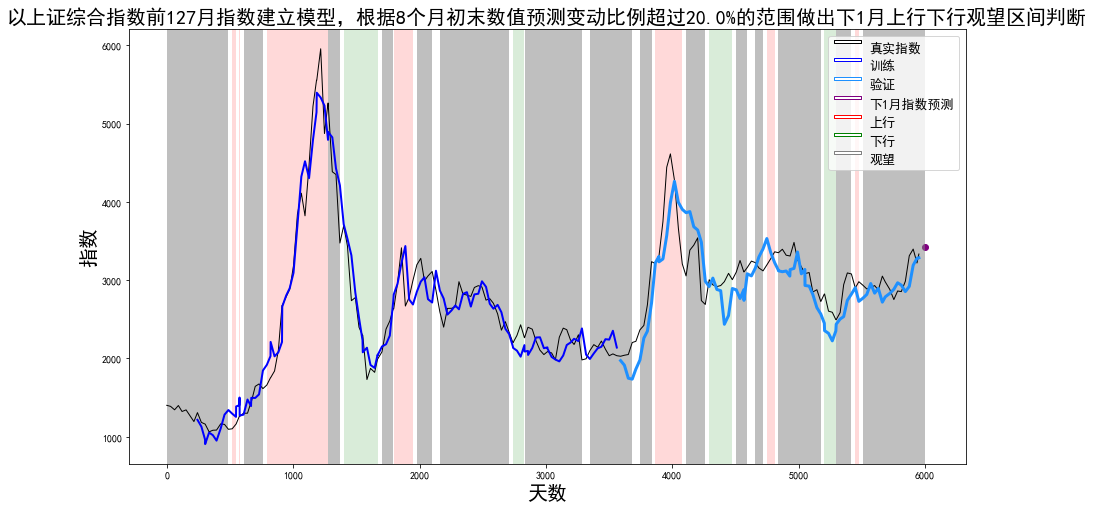

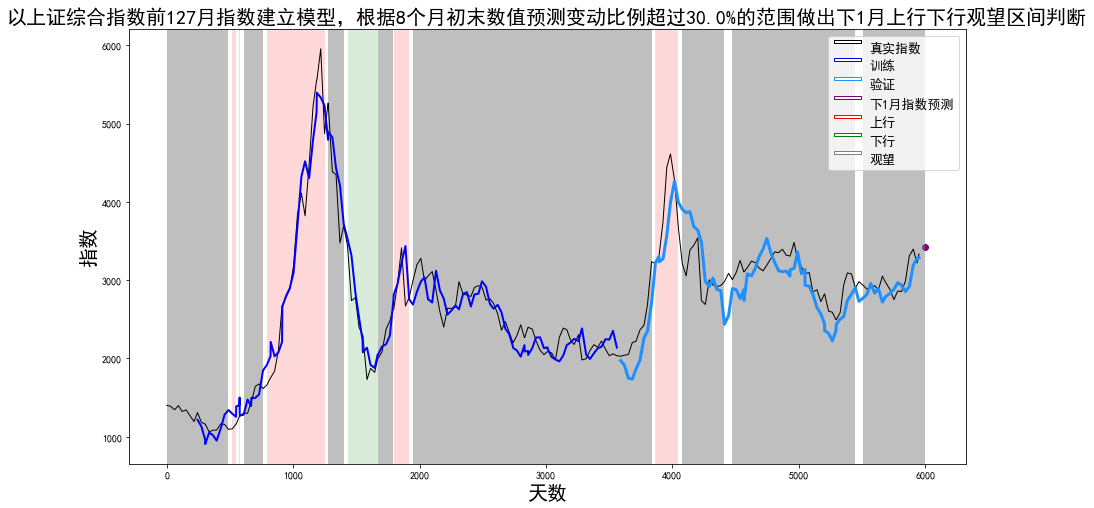

In [5]:
for sl in range(slp):
    sl /= 10

    pred_slope = [0] * len(d8)
    
    for i in range(itv,len(d8)-itv):
        df = t_prd[i-itv:i]
        if df:
            if abs((df[-1]/df[0])-1) > sl:
                pred_slope[i+itv] = (-(-1)**((df[-1]/df[0])-1>0))
    
    
    for i in range(0, len(pred_slope), c_s):
        if sum(pred_slope[i:i+c_s]) == 0:
            pred_slope[i:i+c_s] = [j for j in [0] * c_s]

    plt.rcParams['font.family']=['SimHei']

    d8i = []
    for i in range(len(d8)):
        d8i.append(int((d8[i] - d8[0]).days))
    fig, ax = plt.subplots(figsize=(15,8))
    ax.set_title('以上证综合指数前'+str(si)+dic[prd]+'指数建立模型，根据'+str(itv)+'个'+str(dic[prd])
                 +'初末数值预测变动比例超过'+str(round(sl*100,4))
                 +'%的范围做出下'+str(prdit)+str(dic[prd])+'上行下行观望区间判断'
                 ,fontproperties='SimHei', size = 20)
    ax.plot(d8i[:-1], sh, color='black', linewidth = 1, label = '真实指数')
    ax.plot((d8i[itv:])[:si], tr_prd, c = 'blue', label = '训练', linewidth = 2)
    ax.plot(d8i[si+itv:-prdit], vd_prd[:-1], c = 'dodgerblue', label = '验证', linewidth = 3)
    ax.scatter(d8i[-1], vd_prd[-1], c = 'purple', label = '下'+str(prdit)+str(dic[prd])+'指数预测')
    plt.xlabel(u'天数',fontproperties='SimHei',fontsize = 20)
    plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)
    collection = collections.BrokenBarHCollection.span_where(
        d8i, ymin=0, ymax=max(sh)*1.5, where=np.array(pred_slope) == 1, facecolor='red', alpha=.15, label = '上行')
    ax.add_collection(collection)

    collection = collections.BrokenBarHCollection.span_where(
        d8i, ymin=0, ymax=max(sh)*1.5, where=np.array(pred_slope) == -1, facecolor='green', alpha=.15, label = '下行')
    ax.add_collection(collection)

    collection = collections.BrokenBarHCollection.span_where(
        d8i, ymin=0, ymax=max(sh)*1.5, where=np.array(pred_slope) == 0, facecolor='grey', alpha=.5, label = '观望')
    ax.add_collection(collection)

    new_legends = ["-", "-", "-", '-', '-', "-", '-']
    markers = ['-', '-','-', '-','-', '-', '-']
    colors = ['black', 'blue', 'dodgerblue', 'purple', 'red', 'green', 'grey']

    _, labels = ax.get_legend_handles_labels()

    def dupe_legend(label, color):
        line = Line2D([0], [0], linestyle='none', mfc= 'white',
                    mec=color, marker=r'$\mathregular{{{}}}$'.format(label))
        return line

    duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
    ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

    plt.show()

# 区间划分

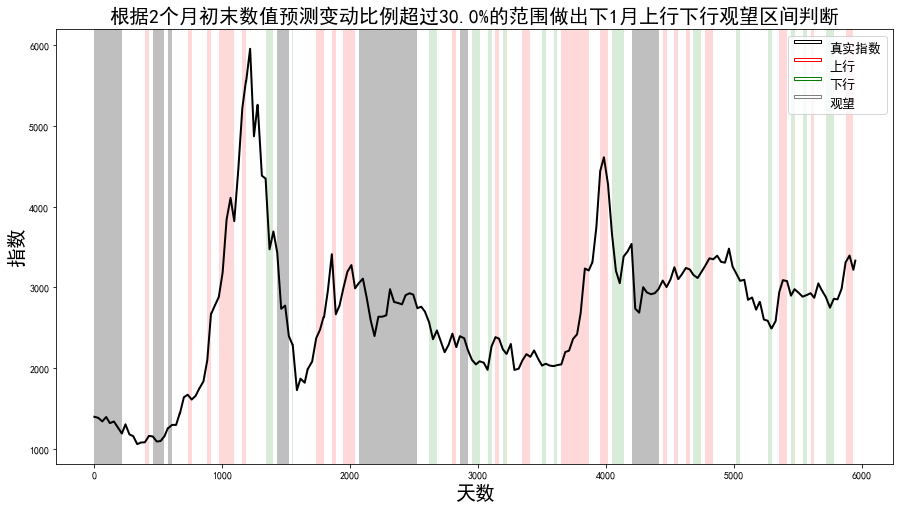

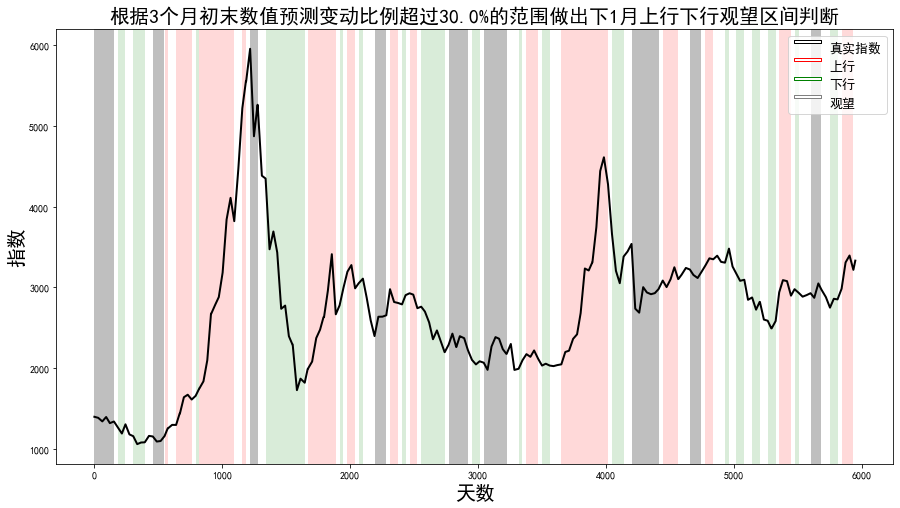

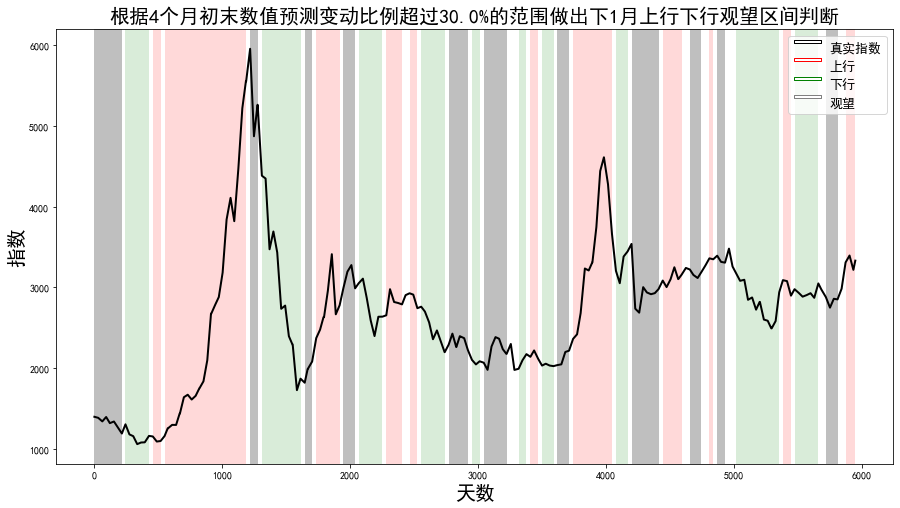

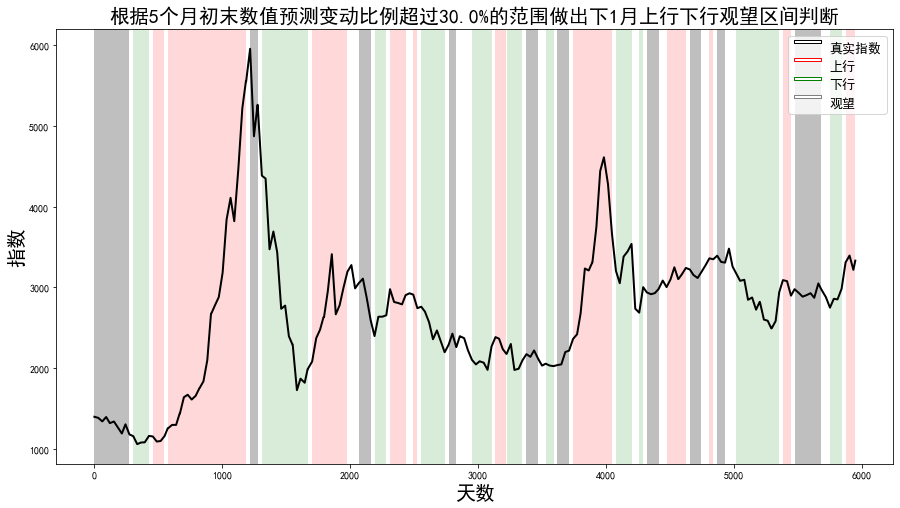

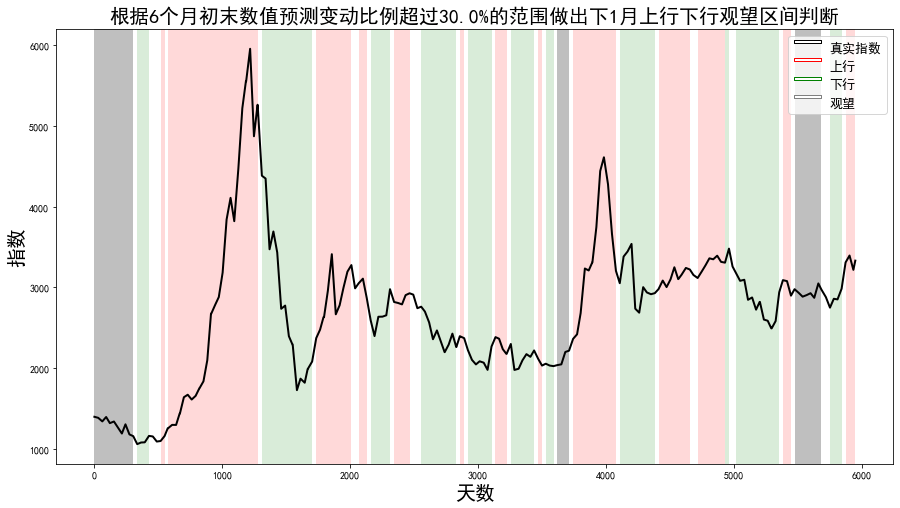

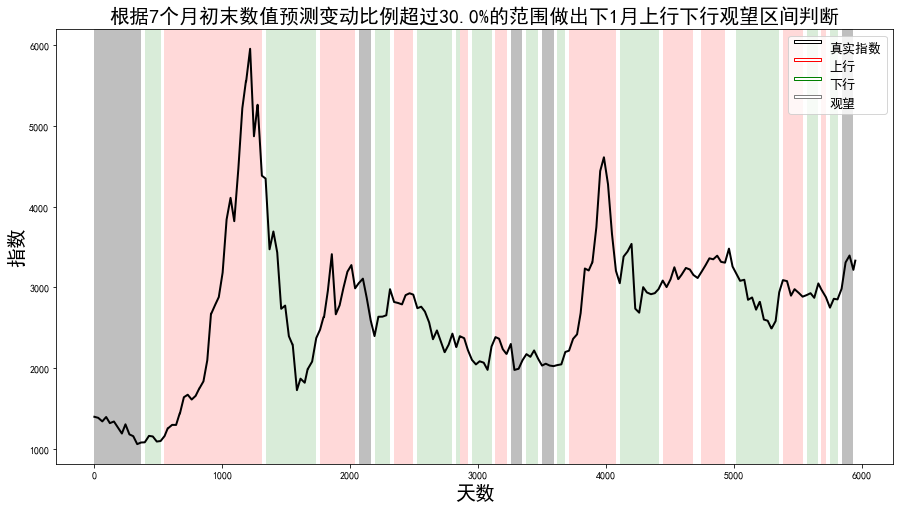

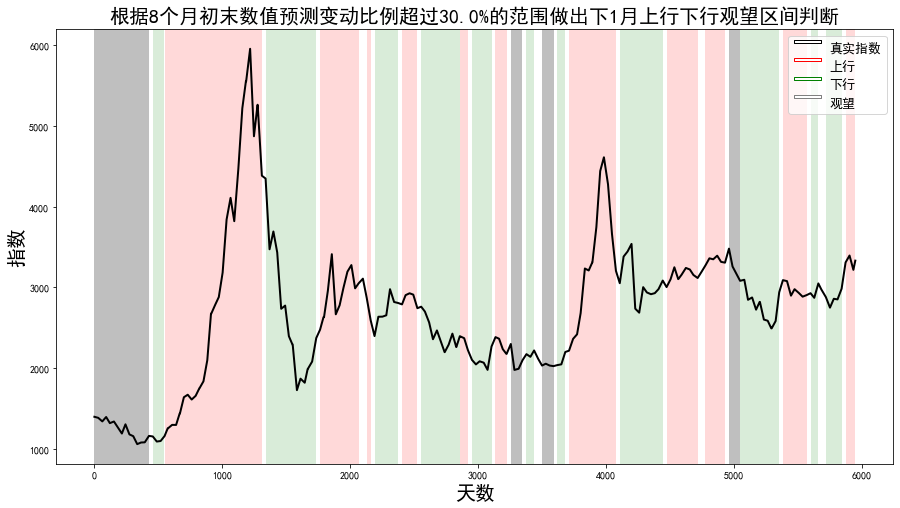

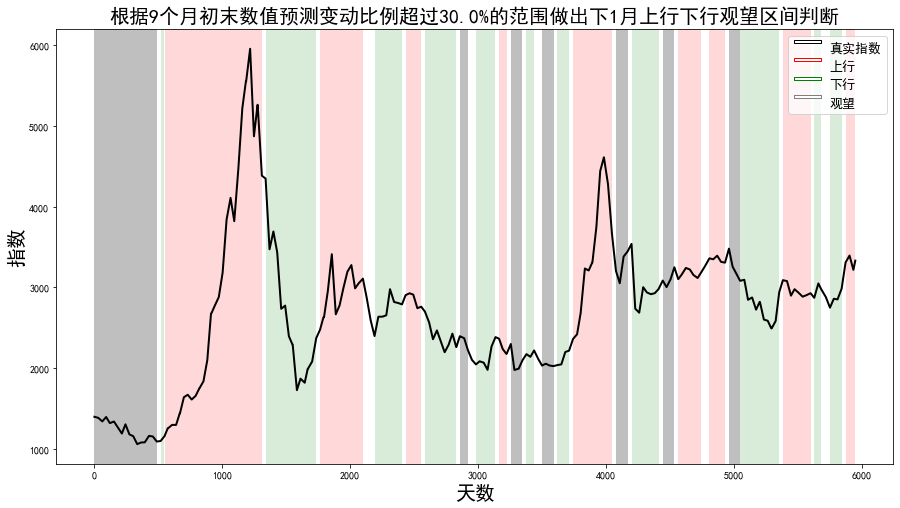

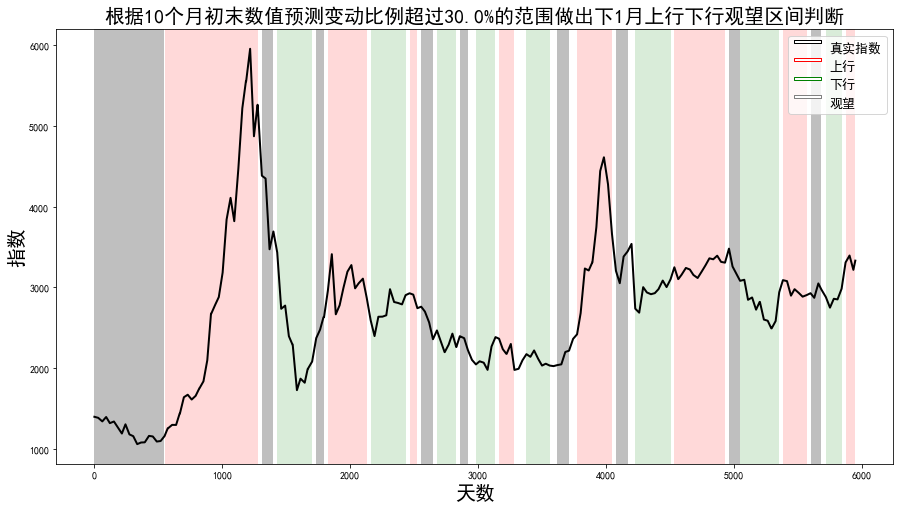

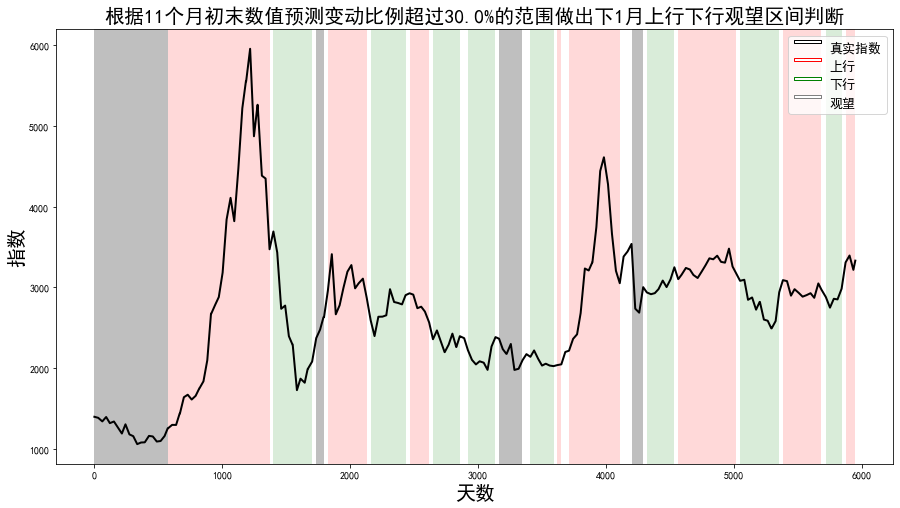

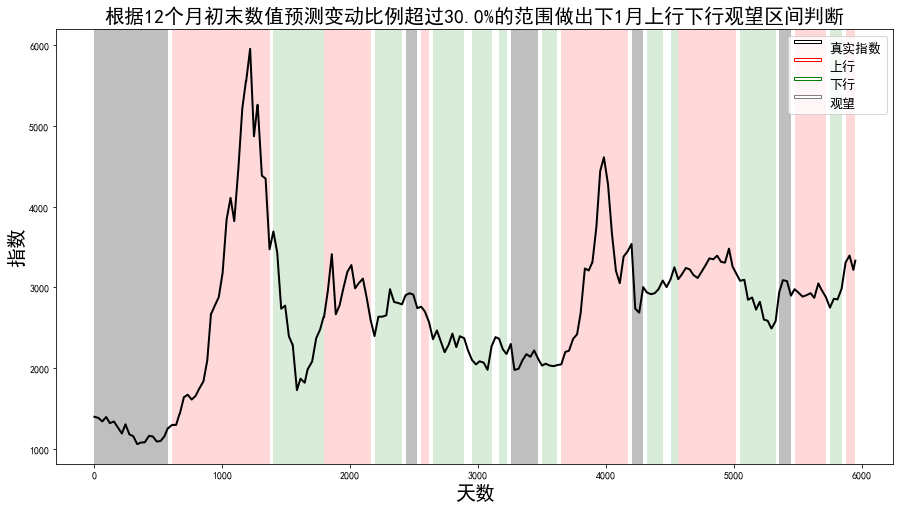

In [53]:
for itv in range(2,13):
    
    ind_list = []
    for i in int_list:
        ind_list.append(i[0])

    d = w.wsd(ind_list, 'close', t0, '-1D', Period = prd, Fill = 'Previous')
    
    data = d.Data
    date = d.Times

    
    pro_df = []
    origin = 0

    for i in range(len(date) - itv - prdit + 2):
        temp = []
        for j in range(len(data)):

            #value指数
            if origin == 1:
                temp.append(data[j][i + itv + prdit - 1])

            df = data[j][i:i+itv]

            #average平均值
            temp.append(sum(df)/itv)

            #spike反转数
            spike = 0
            dirc = -(-1) ** (df[1] > df[0]) 
            for k in range(1,itv-1):
                spike += (-(-1) ** (df[k+1] > df[k]) != dirc)
                dirc = -(-1) ** (df[k+1] > df[k])
            temp.append(spike)

            #slope头尾斜率
            temp.append((df[-1]/df[0])-1)

            #height极值差距
            temp.append(max(df)-min(df))

            #direction头尾方向
            temp.append(-(-1) ** (df[-1] > df[0]))

        pro_df.append(temp)

    pro_df = pro_df[:-1]
    sh = data[0]
    nh = data[1]
    z10 = data[2]
    z1 = data[3]
    d8 = date
    
    pred_slope = [0] * len(d8)

    df_s = [i[2] for i in pro_df]
    for i in range(itv,len(d8)-itv):
        if abs(df_s[i]) > 0:
            pred_slope[i+itv] = (-(-1)**(df_s[i] > 0))


    for i in range(0, len(pred_slope), c_s):
        if sum(pred_slope[i:i+c_s]) == 0:
            pred_slope[i:i+c_s] = [j for j in [0] * c_s]

    x

    fig, ax = plt.subplots(figsize=(15,8))
    ax.set_title('根据'+str(itv)+'个'+str(dic[prd])
                 +'初末数值预测变动比例超过'+str(round(sl*100,4))
                 +'%的范围做出下'+str(prdit)+str(dic[prd])+'上行下行观望区间判断'
                 ,fontproperties='SimHei', size = 20)
    ax.plot(d8i, sh, color='black', linewidth = 2, label = '真实指数')

    plt.xlabel(u'天数',fontproperties='SimHei',fontsize = 20)
    plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)
    collection = collections.BrokenBarHCollection.span_where(
        d8i, ymin=0, ymax=max(sh)*1.5, where=np.array(pred_slope) == 1, facecolor='red', alpha=.15, label = '上行')
    ax.add_collection(collection)

    collection = collections.BrokenBarHCollection.span_where(
        d8i, ymin=0, ymax=max(sh)*1.5, where=np.array(pred_slope) == -1, facecolor='green', alpha=.15, label = '下行')
    ax.add_collection(collection)

    collection = collections.BrokenBarHCollection.span_where(
        d8i, ymin=0, ymax=max(sh)*1.5, where=np.array(pred_slope) == 0, facecolor='grey', alpha=.5, label = '观望')
    ax.add_collection(collection)

    new_legends = ["-", "-", "-", '-']
    markers = ['-', '-','-', '-']
    colors = ['black', 'red', 'green', 'grey']

    _, labels = ax.get_legend_handles_labels()

    def dupe_legend(label, color):
        line = Line2D([0], [0], linestyle='none', mfc= 'white',
                    mec=color, marker=r'$\mathregular{{{}}}$'.format(label))
        return line

    duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
    ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

    plt.show()